#Goal: Assess whether the number of Units per zip code is a good predictor of citibike trips originating from that zip code.

##Motivation: 
CitiBike must distribute bike hubs efficiently. In order to do so it needs a good predictor of the number of rides originating from a location. It is a reasonable assumption that a lot of riders ride from home to their destination. It is also reasonable to assume that if the bikes are far from one's residence the rider would be discouraged from taking a bike.

##Method: 

1) __Fit__ BOTH a first and second degree linear model  (a line and a parabola) to the number of rides per zip code (this is your dependent variable) as a function of number of Residential Units in that zip code (this is your independent variable). 

2) __Display__ your fits graphically with a plot. Describe your plot with a Caption in cell of the notebook


3) __Compare__ you regression with a 1-degree polynomial to your regression with a 2-degree polynomial and __test__ (with the appropriate statistical test) which is better. 

4) Since points at the edge of the x range have a lot of "leverage" (have a large influence on your test) if you find that there are suspicious points at the limit of the independent variable that could be outliers make cuts that remove those points and redo the fits with the 1- and 2-degree polynomial, and test which is better as you did before with a statistical test

5) __Please state in words your findings__. 
State in words the general quality of your prediction. You do not need to be rigorously stating your level of confidence, but do justify your level of belief in your best regression model, and if it seems a good idea to reduce the x range (remove suspicious outliers). 

6) __Discuss__ if the test could be improved: the number of residential units may be a good predictor under specific circumstances (restricting your dataset by any variable, eg only certain times, days, areas, what do you think?), and if you have time test these other hypothesis (for extra credit). Try and imagine what variable could be a better predictor (and if you have time test other vatiables also for extra credit).

##DATA:

   Rides: use at least 2 months of citibike data separated by more than 1/3 of the year (to mitigate seasonal effects). You can fit the 2 datasets separately or join them. Group the rides by 'start station id' (if you do not have the citibike data on your laptop you can get it here https://www.citibikenyc.com/system-data or any 2015 dataset here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/)
 
   Residential Units: Use the Pluto data. Data for Manhattan is available here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/
   Because of the large size of the Brookly file you are only required to do this with the Manhattan data. As Extra Credit: if at the end you have time repeat the analysis with the Brookly data and see if the results are different.

   Zip codes of citibike stations: I prepared a json file with that info for you here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/stationzips.json
   
   

Please label your plots, answer all questions, produce whatever outputs and plots help you in the process but try and remove useless outputs from your final version. Clearly state your answers in separate cells, so they are not lost and we can clearly see them. 

Please make an attempt to be PEP8 compliant. We will not be strict with PEP8 but complete disregard of the "simplest most basic PEP8 rules" will be noticed and repeated violations will be accounted for. If you forgot the simplest most basic PEP8 rules are here (). The complete rules here https://www.python.org/dev/peps/pep-0008/ https://code.google.com/p/soc/wiki/PythonStyleGuide 

As usual, there are many ways to do what you are required to do here, and we do not care which way you do it, which packages you use, how you wrangle and clean your data as long as you do all the tasks that are asked, and answer all the questions that are asked, and obtain results that are not incorrect (of course some ways are more elegant than others but elegance will just earn you extra time, if your code is efficient, and an honor badge and a nod from us, not a higher grade in this midterm). 

If you are comfortable with the description above and have a plan in mind and you need no further instructions go ahead and execute your plan! If you do not have a plan yet I recommend you sit down, collect your thoughts, remember what you have learned this year, try to come up with one and start working on it after you developed a roadmap in your head. 

I have solved this problem in a few ways, and identified what may be difficulties you may encounter. Some hints are available at this link (https://docs.google.com/document/d/13x2cPuBFwdlUyhFTtmMlTiaBkt3FSauHjarWfZx_QhE/edit?usp=sharing), and you are free to refer to them. However, I do recommend you go your own way and rely on what you know and wha you have learned and done so far in the PUI homework. 




In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import pylab as pl
%pylab inline
import json
import scipy.stats 
import urllib2
import statsmodels.api as sm
import statsmodels.formula.api as smf

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Loading and concatenating citibike files

citibike_months = ['201501', '201506']
citibike_files = []
citibike_df = pd.DataFrame()
             
for month in citibike_months:
    citibike_path ='%s-citibike-tripdata.csv' % month
    citibike_frame = pd.read_csv(citibike_path)
    citibike_files.append(citibike_frame)
citibike_df = pd.concat(citibike_files, ignore_index=True)

citibike_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960,2
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963,1
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974,1
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969,1
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977,1


In [10]:
#Loading MapPLUTO data

mappluto_df = gp.GeoDataFrame.from_file("Manhattan/MNMapPLUTO.shp")
print mappluto_df.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

In [3]:
#Loading ZIP code data

zip_url = 'http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/stationzips.json'
request = urllib2.urlopen(zip_url)
zip_data = json.load(request)

zip_data

{u'116': 10011,
 u'119': 11205,
 u'120': 11238,
 u'127': 10014,
 u'128': 10014,
 u'137': 10022,
 u'143': 11201,
 u'144': 11201,
 u'146': 10013,
 u'147': 10007,
 u'150': 10009,
 u'151': 10012,
 u'152': 10007,
 u'153': 10016,
 u'157': 11201,
 u'160': 10016,
 u'161': 10012,
 u'164': 10017,
 u'167': 10016,
 u'168': 10011,
 u'173': 10019,
 u'174': 10016,
 u'195': 10005,
 u'2000': 11201,
 u'2001': 11251,
 u'2002': 11211,
 u'2003': 10009,
 u'2004': 10013,
 u'2005': 11251,
 u'2006': 83,
 u'2008': 10280,
 u'2009': 10038,
 u'2010': 10013,
 u'2012': 10016,
 u'2017': 10017,
 u'2021': 10036,
 u'2022': 10022,
 u'2023': 10022,
 u'212': 10011,
 u'216': 11201,
 u'217': 11201,
 u'218': 11201,
 u'223': 10011,
 u'224': 10038,
 u'225': 10014,
 u'228': 10017,
 u'229': 10012,
 u'232': 11201,
 u'233': 11201,
 u'236': 10003,
 u'237': 10003,
 u'238': 10014,
 u'239': 11201,
 u'241': 11201,
 u'242': 11205,
 u'243': 11217,
 u'244': 11205,
 u'245': 11201,
 u'247': 10014,
 u'248': 10013,
 u'249': 10013,
 u'250': 100

In [4]:
#Including ZIP codes in Citbike df 

citibike_df['start station id'] = citibike_df['start station id'].astype(str)
citibike_df['ZipCode'] = [zip_data[i] for i in citibike_df['start station id']]

citibike_df

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,ZipCode
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960,2,10017
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963,1,10011
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974,1,10010
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969,1,11238
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977,1,10016
5,496,1/1/2015 0:07,1/1/2015 0:15,512,W 29 St & 9 Ave,40.750073,-73.998393,383,Greenwich Ave & Charles St,40.735238,-74.000271,20788,Subscriber,1969,2,10001
6,152,1/1/2015 0:07,1/1/2015 0:09,498,Broadway & W 32 St,40.748549,-73.988084,474,5 Ave & E 29 St,40.745168,-73.986831,19006,Subscriber,1972,1,10001
7,1183,1/1/2015 0:08,1/1/2015 0:28,405,Washington St & Gansevoort St,40.739323,-74.008119,174,E 25 St & 1 Ave,40.738177,-73.977387,17640,Subscriber,1985,2,10014
8,846,1/1/2015 0:09,1/1/2015 0:23,450,W 49 St & 8 Ave,40.762272,-73.987882,488,W 39 St & 9 Ave,40.756458,-73.993722,15691,Subscriber,1991,1,10019
9,576,1/1/2015 0:10,1/1/2015 0:20,160,E 37 St & Lexington Ave,40.748238,-73.978311,174,E 25 St & 1 Ave,40.738177,-73.977387,17837,Subscriber,1991,1,10016


In [11]:
#Grouping Citibike data by ZIP code and counting

citibike_count = pd.DataFrame(citibike_df['start station id'].groupby(citibike_df['ZipCode']).count())
citibike_count['Zip Code'] = citibike_count.index
citibike_count.index = range(0,len(citibike_count))
citibike_count = citibike_count.rename(columns = {'start station id':'Number of Rides'})
citibike_count


,Number of Rides,Zip Code
0,5847,83
1,99100,10001
2,69343,10002
3,131647,10003
4,12617,10004
5,15920,10005
6,31418,10007
7,61616,10009
8,46765,10010
9,106893,10011


In [14]:
#Grouping MapPLUTO data by ZIP code and summing

mappluto_sum = pd.DataFrame(mappluto_df['UnitsRes'].groupby(mappluto_df['ZipCode']).sum())
mappluto_sum['Zip Code'] = mappluto_sum.index
mappluto_sum.index = range(0,len(mappluto_sum))
mappluto_sum = mappluto_sum.rename(columns = {'UnitsRes':'Number of Residential Units'})
mappluto_sum

,Number of Residential Units,Zip Code
0,0,0
1,17940,10001
2,34505,10002
3,33598,10003
4,2409,10004
5,5567,10005
6,2704,10006
7,3732,10007
8,33130,10009
9,19835,10010


In [15]:
#Merging Citibike and MapPLUTO

citipluto = pd.merge(citibike_count, mappluto_sum, on=['Zip Code'])
citipluto = citipluto[(citipluto['Number of Residential Units']>0)]
citipluto

,Number of Rides,Zip Code,Number of Residential Units
0,99100,10001,17940
1,69343,10002,34505
2,131647,10003,33598
3,12617,10004,2409
4,15920,10005,5567
5,31418,10007,3732
6,61616,10009,33130
7,46765,10010,19835
8,106893,10011,35200
9,47560,10012,15412


In [129]:
#Checking if I lost too many observations in the consolidation. I didn't – less than 1,000!

sum(citipluto['Number of Rides'])

1125875

#1) Fit BOTH a first and second degree linear model (a line and a parabola) to the number of rides per zip code (this is your dependent variable) as a function of number of Residential Units in that zip code (this is your independent variable).
#2) Display your fits graphically with a plot. Describe your plot with a Caption in cell of the notebook

In [16]:
#Estimating linear model

X = citipluto['Number of Residential Units']
Y = citipluto['Number of Rides']

model1 = sm.OLS(Y, sm.add_constant(X), mising='drop').fit()
print model1.summary()
print model1.params

                            OLS Regression Results                            
Dep. Variable:        Number of Rides   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     9.689
Date:                Wed, 28 Oct 2015   Prob (F-statistic):            0.00548
Time:                        18:01:21   Log-Likelihood:                -255.99
No. Observations:                  22   AIC:                             516.0
Df Residuals:                      20   BIC:                             518.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
const             

(0, 120000)

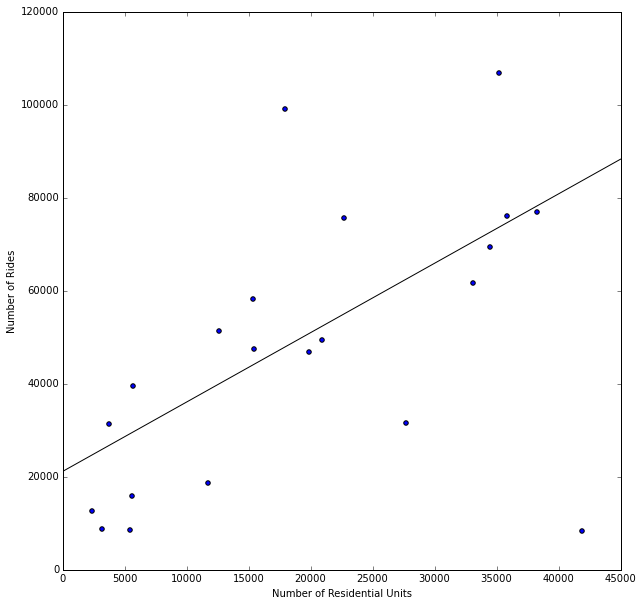

In [17]:
fig1 = pl.figure(figsize=(10, 10))
pl.scatter(X, Y)
XLR1 = arange(0, 45000, 0.1)
YLR1 = model1.params[1]*XLR1+model1.params[0]
pl.plot(XLR1, YLR1, 'black')
plt.xlabel('Number of Residential Units')
plt.ylabel('Number of Rides')
xlim(0, 45000)
ylim(0, 120000)

DESCRIPTON: The plot indicates a positive correlation between the number of rides and the number of residential units per ZIP code. 

#3) Compare you regression with a 1-degree polynomial to your regression with a 2-degree polynomial and test (with the appropriate statistical test) which is better.

In [132]:
#Estimating second degree linear model

model2 = smf.ols(formula = 'Y ~ X + I((X)) + I((X)**2)', 
        data={'X': citipluto['Number of Residential Units'],'Y': citipluto['Number of Rides']}).fit()
print model2.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     8.052
Date:                Wed, 21 Oct 2015   Prob (F-statistic):            0.00293
Time:                        21:34:51   Log-Likelihood:                -253.58
No. Observations:                  22   AIC:                             513.2
Df Residuals:                      19   BIC:                             516.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept   -5338.1385   1.62e+04     -0.330      

In [133]:
secdegree = np.polyfit(X, Y, 2)
secdegree

array([ -9.53660819e-05,   5.49928708e+00,  -5.33813846e+03])

(0, 120000)

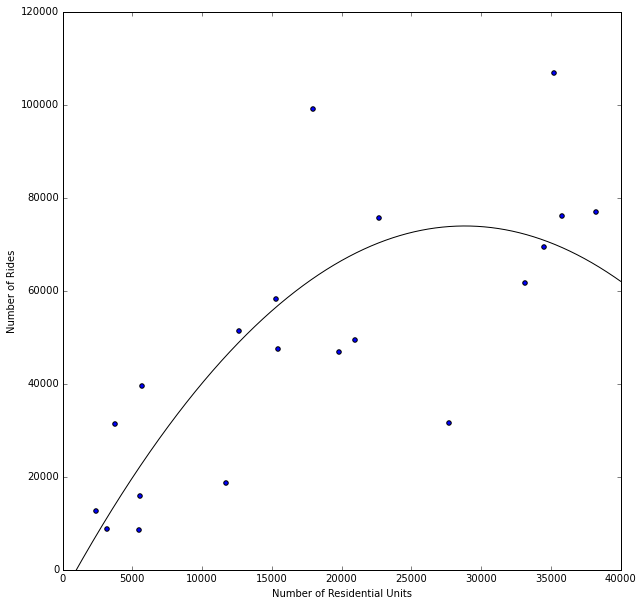

In [134]:
fig2 = pl.figure(figsize=(10, 10))
pl.scatter(X, Y)
XLR2 = arange(0, 45000, 0.1)
YLR2 = secdegree[0]*XLR2**2+secdegree[1]*XLR2+secdegree[2]
pl.plot(XLR2, YLR2, 'black')
plt.xlabel('Number of Residential Units')
plt.ylabel('Number of Rides')
xlim(0, 40000)
ylim(0, 120000)

DESCRIPTON: The plot indicates a positive correlation between the number of rides and the number of residential units per ZIP code until the latter gets close to 30,000. From that level, the fit curve shows that an increase in the number of residential units leads to a decreasing number of rides.

The 2-degree polynomial regression had a significantly higher R2 than the 1-degree regression. An appropriate test to find out which one is better is a likelihood ratio.

In [135]:
print "LR : ", -2 * (model1.llf - (model2.llf))

LR :  4.81380588251


Since my 2-degree polynomial has one incremental parameter vs. my 1-degree polynomial, df=1. Looking at the Chi-Square table, 4.81 is between 1% and 5%. As a result, I would reject that the line is a better fit at a 5% alpha (but not at a 1% one). In any case, it is important to highlight that the aggregation of data in ZIP codes left us with too few observations, which compromises the overall reliability of our conclusions.  

#4) Since points at the edge of the x range have a lot of "leverage" (have a large influence on your test) if you find that there are suspicious points at the limit of the independent variable that could be outliers make cuts that remove those points and redo the fits with the 1- and 2-degree polynomial, and test which is better as you did before with a statistical test

In [216]:
#Excludig ZIP codes with more than 25,000 units

citipluto2 = citipluto[(citipluto['Number of Residential Units']<25000) & (citipluto['Number of Residential Units']>500)]

X2 = citipluto2['Number of Residential Units']
Y2 = citipluto2['Number of Rides']

model3 = sm.OLS(Y2, sm.add_constant(X2), mising='drop').fit()
print model3.summary()
print model3.params

                            OLS Regression Results                            
Dep. Variable:        Number of Rides   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     18.43
Date:                Wed, 21 Oct 2015   Prob (F-statistic):            0.00104
Time:                        23:48:26   Log-Likelihood:                -155.51
No. Observations:                  14   AIC:                             315.0
Df Residuals:                      12   BIC:                             316.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
const             

(0, 120000)

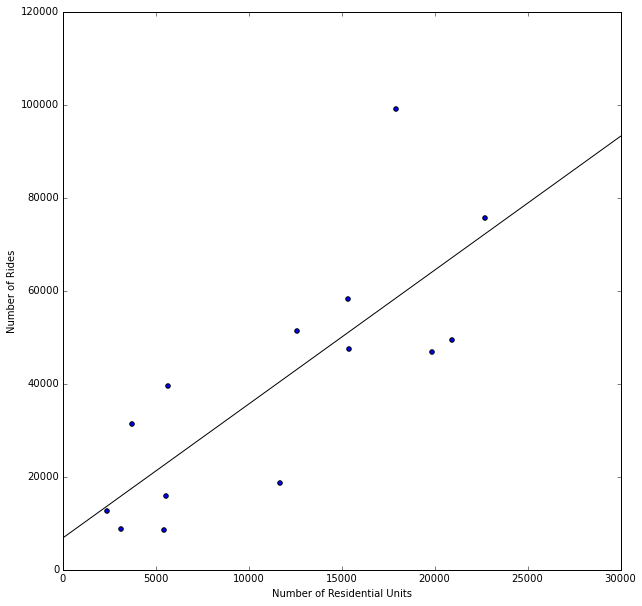

In [217]:
#Estimating linear model

fig3 = pl.figure(figsize=(10, 10))
pl.scatter(X2, Y2)
XLR3 = arange(0, 30000, 0.1)
YLR3 = model3.params[1]*XLR3+model3.params[0]
pl.plot(XLR3, YLR3, 'black')
plt.xlabel('Number of Residential Units')
plt.ylabel('Number of Rides')
xlim(0, 30000)
ylim(0, 120000)

DESCRIPTON: The plot indicates a positive correlation between the number of rides and the number of residential units per ZIP code.

In [218]:
#Estimating second degree linear model

model4 = smf.ols(formula = 'Y ~ X + I((X)) + I((X)**2)', 
        data={'X': citipluto2['Number of Residential Units'],'Y': citipluto2['Number of Rides']}).fit()
print model4.summary()

secdegree2 = np.polyfit(X2, Y2, 2)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     8.520
Date:                Wed, 21 Oct 2015   Prob (F-statistic):            0.00582
Time:                        23:49:11   Log-Likelihood:                -155.48
No. Observations:                  14   AIC:                             317.0
Df Residuals:                      11   BIC:                             318.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    3561.1745   1.66e+04      0.215      

(0, 120000)

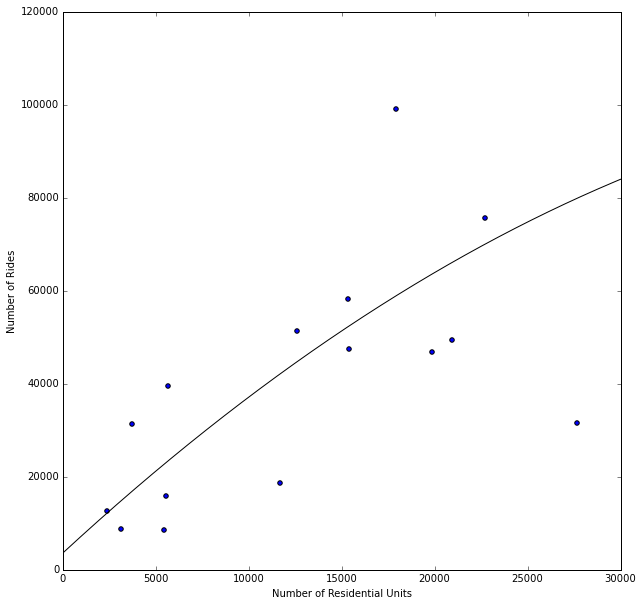

In [219]:
fig4 = pl.figure(figsize=(10, 10))
pl.scatter(X, Y)
XLR4 = arange(0, 30000, 0.1)
YLR4 = secdegree2[0]*XLR4**2+secdegree2[1]*XLR4+secdegree2[2]
pl.plot(XLR4, YLR4, 'black')
plt.xlabel('Number of Residential Units')
plt.ylabel('Number of Rides')
xlim(0, 30000)
ylim(0, 120000)

DESCRIPTON: The plot indicates a positive correlation between the number of rides and the number of residential units per ZIP code.

In [220]:
print "LR : ", -2 * (model3.llf - (model4.llf))

LR :  0.0719479023618


Since my 2-degree polynomial has one incremental parameter vs. my 1-degree polynomial, df=1. Looking at the Chi-Square table, 0.072 is between 75% and 90%. As a result, I would not reject that the line is a better fit at a 5% alpha.

#5) Please state in words your findings. State in words the general quality of your prediction. You do not need to be rigorously stating your level of confidence, but do justify your level of belief in your best regression model, and if it seems a good idea to reduce the x range (remove suspicious outliers).


The grouping of the data per Manhattan ZIP code left me with only 22 observations, which is a limited number for our regression. In any case, I have found a positive correlation between number of rides and number of residential units in all my models. The removal of outliers proved beneficial for my R2, which is positive, altough at least graphically they did not seem that suspect for me (which is one the difficulties created by too few observations).

#6) Discuss if the test could be improved: the number of residential units may be a good predictor under specific circumstances (restricting your dataset by any variable, eg only certain times, days, areas, what do you think?), and if you have time test these other hypothesis (for extra credit). Try and imagine what variable could be a better predictor (and if you have time test other vatiables also for extra credit).

The test could be definitely improved if the data was not grouped by ZIP code, which severely limits the number of observations. I would group the data differentyly, maybe per group of BBLs encompassing a smaller area than a ZIP. In terms of predictor on a standalone basis, maybe population density could be more accurate than total number of residential units, as our focus is the potential number of citibike riders. Another crucial factor is that we are not taking into consideration the presence of citibike stations where people actually leave, which largely influences their decision to use the service. Lastly, the time is also crucial: people are more prone to take bikes close to where they live in the morning (or so I suppose!) 

#EXTRA CREDIT: Adding Brooklyn

#1) Fit BOTH a first and second degree linear model (a line and a parabola) to the number of rides per zip code (this is your dependent variable) as a function of number of Residential Units in that zip code (this is your independent variable).

#2) Display your fits graphically with a plot. Describe your plot with a Caption in cell of the notebook

In [141]:
#Loading Brooklyn data

bkmappluto_df = gp.GeoDataFrame.from_file("Brooklyn/BKMapPLUTO.shp")

In [142]:
#Grouping MapPLUTO data by ZIP code and summing

bkmappluto_sum = pd.DataFrame(bkmappluto_df['UnitsRes'].groupby(bkmappluto_df['ZipCode']).sum())
bkmappluto_sum['Zip Code'] = bkmappluto_sum.index
bkmappluto_sum.index = range(0,len(bkmappluto_sum))
bkmappluto_sum = bkmappluto_sum.rename(columns = {'UnitsRes':'Number of Residential Units'})
bkmappluto_sum

,Number of Residential Units,Zip Code
0,0,0
1,34398,11201
2,26948,11203
3,27364,11204
4,17993,11205
5,31714,11206
6,32926,11207
7,28605,11208
8,32605,11209
9,22913,11210


In [144]:
#Merging Citibike and MapPLUTO

bkcitipluto = pd.merge(citibike_count, bkmappluto_sum, on=['Zip Code'])
bkcitipluto = bkcitipluto[(citipluto['Number of Residential Units']>0)]
bkcitipluto

,Number of Rides,Zip Code,Number of Residential Units
0,39542,11201,34398
1,14199,11205,17993
2,13169,11211,28505
3,1685,11216,25083
4,9378,11217,19569
5,5563,11238,27388


In [162]:
#Since Brooklyn has too few observations, I will merge the dataframes and will do the analysis with Manhattan + Brooklyn

mnbkcitipluto = pd.concat([citipluto, bkcitipluto])
mnbkcitipluto.index = range(0,len(mnbkcitipluto))
mnbkcitipluto

,Number of Rides,Zip Code,Number of Residential Units
0,99100,10001,17940
1,69343,10002,34505
2,131647,10003,33598
3,12617,10004,2409
4,15920,10005,5567
5,31418,10007,3732
6,61616,10009,33130
7,46765,10010,19835
8,106893,10011,35200
9,47560,10012,15412


                            OLS Regression Results                            
Dep. Variable:        Number of Rides   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     5.448
Date:                Wed, 21 Oct 2015   Prob (F-statistic):             0.0276
Time:                        22:47:19   Log-Likelihood:                -329.01
No. Observations:                  28   AIC:                             662.0
Df Residuals:                      26   BIC:                             664.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
const             

(0, 120000)

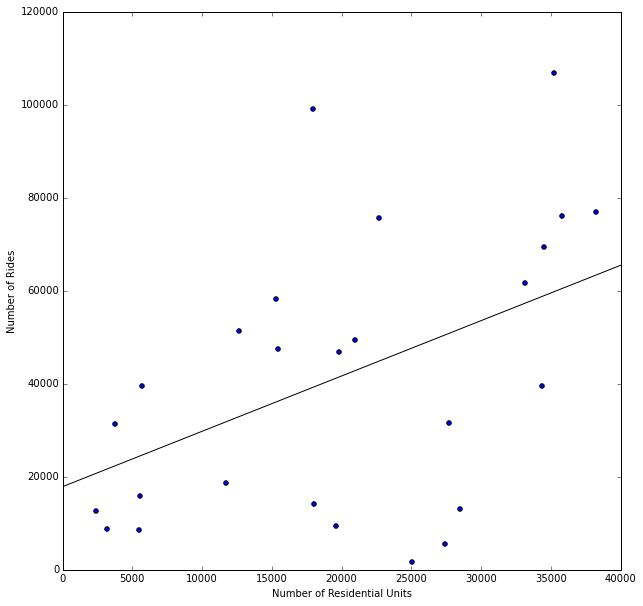

In [172]:
#Estimating linear model

X3 = mnbkcitipluto['Number of Residential Units']
Y3 = mnbkcitipluto['Number of Rides']

model5 = sm.OLS(Y3, sm.add_constant(X3), mising='drop').fit()
print model5.summary()
print model5.params

fig5 = pl.figure(figsize=(10, 10))
pl.scatter(X3, Y3)
XLR5 = arange(0, 45000, 0.1)
YLR5 = model5.params[1]*XLR5+model5.params[0]
pl.plot(XLR5, YLR5, 'black')
plt.xlabel('Number of Residential Units')
plt.ylabel('Number of Rides')
xlim(0, 40000)
ylim(0, 120000)

DESCRIPTON: The plot indicates a positive correlation between the number of rides and the number of residential units per ZIP code.

#3) Compare you regression with a 1-degree polynomial to your regression with a 2-degree polynomial and test (with the appropriate statistical test) which is better.

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     2.721
Date:                Wed, 21 Oct 2015   Prob (F-statistic):             0.0853
Time:                        22:47:12   Log-Likelihood:                -328.92
No. Observations:                  28   AIC:                             663.8
Df Residuals:                      25   BIC:                             667.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    1.194e+04   1.92e+04      0.622      

(0, 120000)

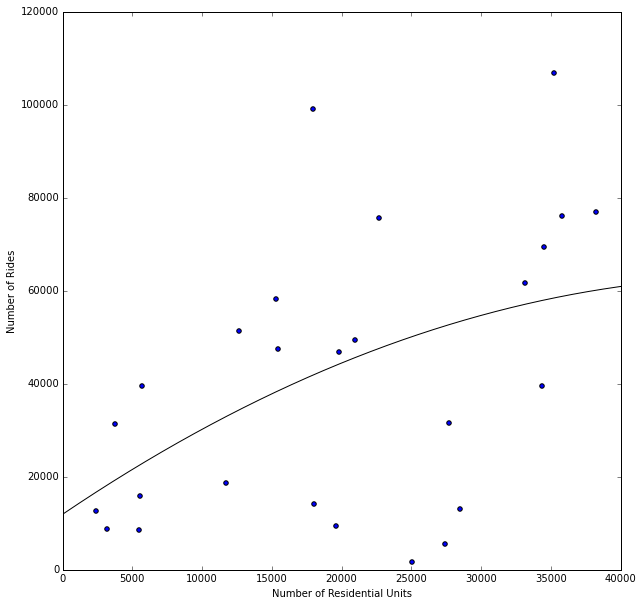

In [171]:
#Estimating second degree linear model

model6 = smf.ols(formula = 'Y ~ X + I((X)) + I((X)**2)', 
        data={'X': mnbkcitipluto['Number of Residential Units'],'Y': mnbkcitipluto['Number of Rides']}).fit()
print model6.summary()

secdegree3 = np.polyfit(X3, Y3, 2)

fig6 = pl.figure(figsize=(10, 10))
pl.scatter(X3, Y3)
XLR5 = arange(0, 45000, 0.1)
YLR5 = secdegree3[0]*XLR5**2+secdegree3[1]*XLR5+secdegree3[2]
pl.plot(XLR5, YLR5, 'black')
plt.xlabel('Number of Residential Units')
plt.ylabel('Number of Rides')
xlim(0, 40000)
ylim(0, 120000)

DESCRIPTON:  The plot indicates a positive correlation between the number of rides and the number of residential units per ZIP code, although the number of rides tend to stabilize after towards the high-end of the number of residential units. The R2 is just slightly higher than the previous regression. I believe the overall fit is worse than the Manhattan-only regressions given the high density of Brooklyn combined with the restricted availability of the service. 

In [168]:
#Calculating the likelihood ratio

print "LR : ", -2 * (model5.llf - (model6.llf))

LR :  0.188211345164


Since my 2-degree polynomial has one incremental parameter vs. my 1-degree polynomial, df=1. Looking at the Chi-Square table, 0.188 is between 50% and 75%. As a result, I would not reject that the line is a better fit at a 5% alpha.

#4) Since points at the edge of the x range have a lot of "leverage" (have a large influence on your test) if you find that there are suspicious points at the limit of the independent variable that could be outliers make cuts that remove those points and redo the fits with the 1- and 2-degree polynomial, and test which is better as you did before with a statistical test.


In [179]:
#Excludig ZIP codes with more than 35,000 units

mnbkcitipluto2 = mnbkcitipluto[(mnbkcitipluto['Number of Residential Units']<35000)]

X4 = mnbkcitipluto2['Number of Residential Units']
Y4 = mnbkcitipluto2['Number of Rides']

model7 = sm.OLS(Y4, sm.add_constant(X4), mising='drop').fit()
print model7.summary()
print model7.params

                            OLS Regression Results                            
Dep. Variable:        Number of Rides   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     4.187
Date:                Wed, 21 Oct 2015   Prob (F-statistic):             0.0529
Time:                        22:48:34   Log-Likelihood:                -280.65
No. Observations:                  24   AIC:                             565.3
Df Residuals:                      22   BIC:                             567.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
const             

In [181]:
#Estimating second degree linear model

model8 = smf.ols(formula = 'Y ~ X + I((X)) + I((X)**2)', 
        data={'X': mnbkcitipluto2['Number of Residential Units'],'Y': mnbkcitipluto2['Number of Rides']}).fit()
print model8.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     2.014
Date:                Wed, 21 Oct 2015   Prob (F-statistic):              0.158
Time:                        22:49:50   Log-Likelihood:                -280.63
No. Observations:                  24   AIC:                             567.3
Df Residuals:                      21   BIC:                             570.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    1.915e+04   1.97e+04      0.972      

DESCRIPTION: Our data cut did not lead to any improvement in R2 (this was actually test, as based on the plots the points did not look "suspicious").

#5) Please state in words your findings. State in words the general quality of your prediction. You do not need to be rigorously stating your level of confidence, but do justify your level of belief in your best regression model, and if it seems a good idea to reduce the x range (remove suspicious outliers).

The overall level of my predictions for Manhattan + Brooklyn, based on R2's and plots, were lower than for Manhattan on a standalone basis. As I have mentioned, this is largely due to the Brooklyn points, as they have a high residential density and a somewhat low number of rides when compared to Manhattan, which is most likely attributed to the availability of the service. 

#6) Discuss if the test could be improved: the number of residential units may be a good predictor under specific circumstances (restricting your dataset by any variable, eg only certain times, days, areas, what do you think?), and if you have time test these other hypothesis (for extra credit). Try and imagine what variable could be a better predictor (and if you have time test other vatiables also for extra credit).

Based on my answer above, the test would be definitely improved by considering the level of service provided in each location (apart from the other factors from my previous answer to this question).

#EXTRA CREDIT: Limiting rides to the morning

As I mentioned above, people are more likely to use citibike close to where they live in the mornig period. I will therefore try to run tests for the combined population of Manhattan, but just in the morning period (between 5 and 12 PM).

In [188]:
#Adding hour column

citibike_df['hour'] = pd.DatetimeIndex(citibike_df['starttime']).hour
citibike_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,ZipCode,hour
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960,2,10017,0
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963,1,10011,0
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974,1,10010,0
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969,1,11238,0
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977,1,10016,0


In [195]:
#Cutting data

citibikeAM = citibike_df[(citibike_df['hour']>5) & (citibike_df['hour']<12)]

In [196]:
#Grouping Citibike AM data by ZIP code and counting

citibikeAM_count = pd.DataFrame(citibikeAM['start station id'].groupby(citibikeAM['ZipCode']).count())
citibikeAM_count['Zip Code'] = citibikeAM_count.index
citibikeAM_count.index = range(0,len(citibikeAM_count))
citibikeAM_count = citibikeAM_count.rename(columns = {'start station id':'Number of Rides'})
citibikeAM_count

,Number of Rides,Zip Code
0,1326,83
1,36970,10001
2,24250,10002
3,35046,10003
4,1844,10004
5,3538,10005
6,8288,10007
7,26046,10009
8,12202,10010
9,29806,10011


In [197]:
#Merging Citibike AM and MapPLUTO

citiAMpluto = pd.merge(citibikeAM_count, mappluto_sum, on=['Zip Code'])
citiAMpluto = citiAMpluto[(citiAMpluto['Number of Residential Units']>0)]
citiAMpluto

,Number of Rides,Zip Code,Number of Residential Units
0,36970,10001,17940
1,24250,10002,34505
2,35046,10003,33598
3,1844,10004,2409
4,3538,10005,5567
5,8288,10007,3732
6,26046,10009,33130
7,12202,10010,19835
8,29806,10011,35200
9,10570,10012,15412


                            OLS Regression Results                            
Dep. Variable:        Number of Rides   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     9.718
Date:                Wed, 21 Oct 2015   Prob (F-statistic):            0.00543
Time:                        23:30:07   Log-Likelihood:                -230.98
No. Observations:                  22   AIC:                             466.0
Df Residuals:                      20   BIC:                             468.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
const             

(0, 40000)

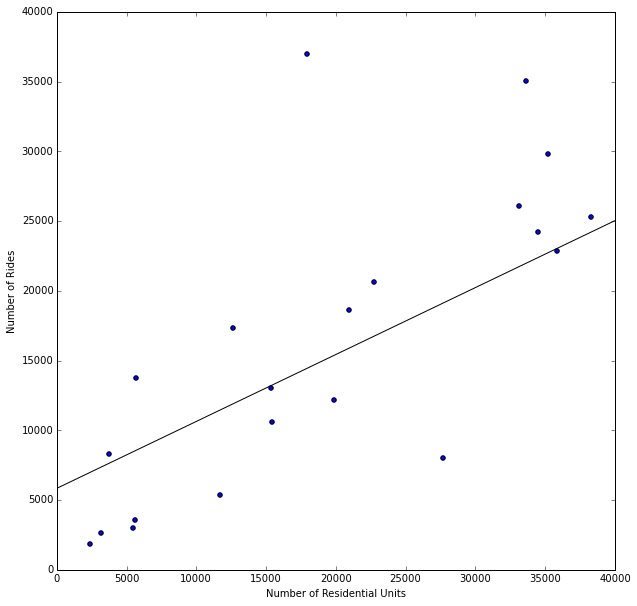

In [204]:
#Estimating linear model

X5 = citiAMpluto['Number of Residential Units']
Y5 = citiAMpluto['Number of Rides']

model9 = sm.OLS(Y5, sm.add_constant(X5), mising='drop').fit()
print model9.summary()
print model9.params

fig7 = pl.figure(figsize=(10, 10))
pl.scatter(X5, Y5)
XLR9 = arange(0, 45000, 0.1)
YLR9 = model9.params[1]*XLR9+model9.params[0]
pl.plot(XLR9, YLR9, 'black')
plt.xlabel('Number of Residential Units')
plt.ylabel('Number of Rides')
xlim(0, 40000)
ylim(0, 40000)

COMMENT: Our R2 did not significantly change by including only the morning data. However, we should still try a 2nd-degree regression.

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     7.883
Date:                Wed, 21 Oct 2015   Prob (F-statistic):            0.00321
Time:                        23:32:04   Log-Likelihood:                -228.69
No. Observations:                  22   AIC:                             463.4
Df Residuals:                      19   BIC:                             466.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept   -2470.6419   5215.083     -0.474      

(0, 40000)

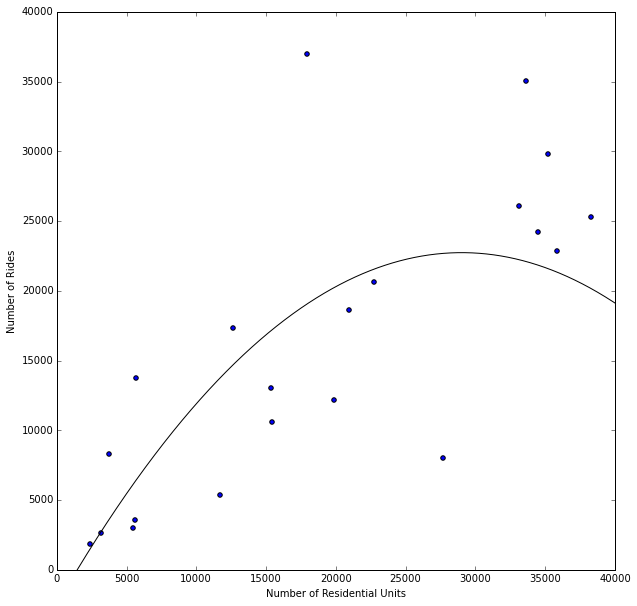

In [207]:
#Estimating second degree linear model

model10 = smf.ols(formula = 'Y ~ X + I((X)) + I((X)**2)', 
        data={'X': citiAMpluto['Number of Residential Units'],'Y': citiAMpluto['Number of Rides']}).fit()
print model10.summary()

secdegree4 = np.polyfit(X5, Y5, 2)

fig8 = pl.figure(figsize=(10, 10))
pl.scatter(X5, Y5)
XLR8 = arange(0, 45000, 0.1)
YLR8 = secdegree4[0]*XLR8**2+secdegree4[1]*XLR8+secdegree4[2]
pl.plot(XLR8, YLR8, 'black')
plt.xlabel('Number of Residential Units')
plt.ylabel('Number of Rides')
xlim(0, 40000)
ylim(0, 40000)

DESCRIPTON: The plot indicates a positive correlation between the number of rides and the number of residential units per ZIP code until the latter gets close to 30,000. From that level, the fit curve shows that an increase in the number of residential units leads to a decreasing number of rides. Our R2 continues not to show improvement vs the uncut data, which I find counter-intuitive. 